In [1]:
# default_exp models

# Import

In [2]:
#export
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from IPython.core.debugger import set_trace
from PIL import Image

from style_transfer.data import *

# Config

In [3]:
dir_data = Path('data')
dir_cont = dir_data/'content'
dir_styl = dir_data/'style'

# Utility

In [4]:
#export
def img2tensor(img, normalize=True, cuda=True, batchify=True):
    img = F.to_tensor(img)
    if normalize: img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    if cuda:      img = img.cuda()
    if batchify:  img = img[None]  
    return img

In [5]:
#export
def leaf_modules(model): # TODO: does pytorch have a built-in for this?
    for m in model.modules():
        if len(list(m.children())) == 0:
            yield m

In [6]:
#export
def gram_matrix(x):
    n,c,h,w = x.shape
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [7]:
#export
def get_in_channels(module):
    # Gets in_channels of first conv layer
    in_channels = None
    for m in leaf_modules(module):
        if isinstance(m, nn.modules.conv._ConvNd):
            in_channels = m.in_channels
            break
    return in_channels

In [8]:
#export
def get_out_channels(module):
    # Gets out_channels of last conv layer
    out_channels = None
    for m in leaf_modules(module):
        if isinstance(m, nn.modules.conv._ConvNd):
            out_channels = m.out_channels
    return out_channels

In [9]:
#export 
class reflection_conv(nn.Module):
    def __init__(self, ic, oc, ks, s, b=True):
        super().__init__()        
        self.pad = nn.ReflectionPad2d((ks-1)//2)
        self.conv = nn.Conv2d(ic, oc, ks, s, bias=b)
        
    def forward(self, X):
        X = self.pad(X)
        return self.conv(X)

In [10]:
#export
def conv_layer(ic, oc, ks, s):
    return nn.Sequential(
        reflection_conv(ic, oc, ks, s, b=False), # No bias needed since norm layer
        nn.GroupNorm(1, oc),
        nn.ReLU(inplace=True)
    )

In [11]:
#export
class res_block(nn.Module):
    def __init__(self, c, ks):
        super().__init__()
        self.conv1 = conv_layer(c, c, ks, 1)
        self.conv2 = conv_layer(c, c, ks, 1)
        
    def forward(self, X):
        return self.conv2(self.conv1(X)) + X

In [12]:
#export
class Halve(nn.Module):
    def __init__(self): 
        super().__init__()
        
    def forward(self, X): 
        return nn.functional.interpolate(X, scale_factor=0.5, mode='bilinear', align_corners=True)

In [13]:
#export
class Double(nn.Module):
    def __init__(self): 
        super().__init__()
        
    def forward(self, X): 
        return nn.functional.interpolate(X, scale_factor=2, mode='bilinear', align_corners=True)

In [14]:
#export
def get_encoder(ic, layout_e):
    prev_oc = ic
    encoder = []
    for idx_l, layout_l in enumerate(layout_e):
        c, ks, num_blocks = layout_l       
        layer = [conv_layer(prev_oc, c, 3, 1)]
        for idx_b in range(num_blocks):            
            layer.append(res_block(c, ks))
        encoder.append(nn.Sequential(*layer))        
        if idx_l < len(layout_e)-1:
            encoder.append(Halve())
        prev_oc = c
    return nn.Sequential(*encoder)

# Feature loss

In [15]:
#export
class FeatureLoss():
    def __init__(self, encoder, img_styl, sz, idx_styl, idx_cont, w_styl, w_cont):
        # Set up encoder
        encoder = encoder.cuda()
        encoder.eval()
        for p in encoder.parameters(): p.requires_grad = False
        self.encoder = encoder

        # Use hooks + dummy pass to get feature modules (modules right before size change)
        def _hook(module, x, y): 
            if x[0].shape[2:] != y.shape[2:]:
                module.size_changed = True                
        hooks = [m.register_forward_hook(_hook) for m in leaf_modules(encoder)]
        encoder(torch.zeros(1, 3, sz, sz, device='cuda'))        
        m_feats, m_prev = [], None
        for m in leaf_modules(encoder):
            if hasattr(m, 'size_changed'):
                m_feats.append(m_prev)
            m_prev = m
        for h in hooks: h.remove()
        self.m_feats = m_feats
            
        # Hook modules for style and content loss
        def _hook(module, x, y): module.x = x[0]
        self.hooks = [self.m_feats[idx].register_forward_hook(_hook) for idx in set(idx_styl+idx_cont)]
        self.idx_styl, self.idx_cont = idx_styl, idx_cont
                            
        # Precompute style image gram matrix; these are constant
        self.encoder(img2tensor(img_styl))
        self.gms_styl = [gram_matrix(feat) for feat in self._get_styl_feats()]
        
        # Store weights
        self.w_styl, self.w_cont = w_styl, w_cont
        
    def _get_styl_feats(self):
        return [self.m_feats[idx].x for idx in self.idx_styl]

    def _get_cont_feats(self):
        return [self.m_feats[idx].x for idx in self.idx_cont]

    def __call__(self, y_hat, y):        
        # content target
        self.encoder(y)
        feats_cc = self._get_cont_feats()
        
        # network output - this should learn to normalize to imagenet stats?
        self.encoder(y_hat)
        feats_hs = self._get_styl_feats()
        feats_hc = self._get_cont_feats()
                            
        # Get losses
        loss = nn.functional.mse_loss        
        ls_s = [self.w_styl[idx]*loss(self.gms_styl[idx].repeat(feat_hs.shape[0],1,1), gram_matrix(feat_hs)) 
                for idx, feat_hs in enumerate(feats_hs)]
        ls_c = [self.w_cont[idx]*loss(feat_cc, feat_hc) 
                for idx, (feat_cc, feat_hc) in enumerate(zip(feats_cc, feats_hc))]
        l_s, l_c = map(sum, [ls_s, ls_c])
        l = l_s + l_c
        
        # Metrics
        metrics = {}
        for name_metric in self.get_metric_names(): 
            metrics[name_metric] = eval(name_metric + '.item()')

        return l, metrics
    
    def get_metric_names(self):
        return ['l'] + \
               [f'ls_s[{i}]' for i in range(len(self.idx_styl))] + \
               [f'ls_c[{i}]' for i in range(len(self.idx_cont))]
    
    def __del__(self): 
        for h in self.hooks: h.remove()

# Model

In [16]:
#export
class AutoEncoder(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = self._get_decoder(encoder)
        
    def _get_decoder(self, encoder):
        decoder = []
        for idx, m in enumerate(reversed(encoder)):
            layer = []
            if isinstance(m, Halve):
                layer.append(Double())
            else:
                ic, oc = get_out_channels(m), get_in_channels(m)
                layer.append(res_block(ic, 3))
                if idx < len(encoder)-1:
                    layer.append(conv_layer(ic, oc, 3, 1))
                else:
                    # Last layer; dont do relu, norm, or upsampling
                    layer.append(reflection_conv(ic, oc, 3, 1))
            decoder.append(nn.Sequential(*layer))
        return nn.Sequential(*decoder)

    def forward(self, X):
        return self.decoder(self.encoder(X))

# Test

In [17]:
sz = 256

In [18]:
encoder = models.vgg16(pretrained=True).features

In [19]:
loss = FeatureLoss(encoder, 
                   Image.open(dir_styl/'hiroshige_winter.jpg'), 
                   sz, 
                   [0,1,2,3], 
                   [1],
                   [1e10, 1e10, 1e10, 1e10],
                   [1e5])

In [20]:
in_channels = 3

# [channels, kernel_size, num_res_blocks]
layout_encoder = [[  32, 3, 1],
                  [  64, 3, 1],
                  [ 128, 3, 1],
                  [ 256, 3, 2]]

encoder = get_encoder(in_channels, layout_encoder)

In [21]:
model = AutoEncoder(encoder)
model = model.cuda()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): reflection_conv(
          (pad): ReflectionPad2d((1, 1, 1, 1))
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        )
        (1): GroupNorm(1, 32, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
      (1): res_block(
        (conv1): Sequential(
          (0): reflection_conv(
            (pad): ReflectionPad2d((1, 1, 1, 1))
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          )
          (1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): reflection_conv(
            (pad): ReflectionPad2d((1, 1, 1, 1))
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          )
          (1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (1): Halve

In [22]:
dir_imgs = Path(dir_cont/f'formatted_{sz}'/'trn'/'imgs')
file_trn = dir_cont/'trn.csv'

In [23]:
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])])

In [24]:
ds_trn = ImgCSVDataset(dir_imgs, file_trn, tfms=tfms)

In [25]:
X,y = ds_trn[0]
X,y = X[None], y[None]
X,y = X.cuda(), y.cuda()

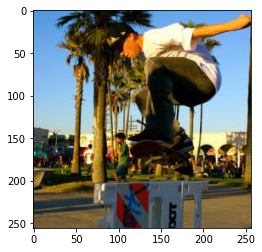

In [26]:
img = torch2np(X[0])
plt.imshow(denorm(img))

In [27]:
y_hat = model(X)

In [28]:
loss(y_hat, y)

(tensor(4515013.5000, device='cuda:0', grad_fn=<AddBackward0>),
 {'l': 4515013.5,
  'ls_s[0]': 1650037.875,
  'ls_s[1]': 1407202.25,
  'ls_s[2]': 409812.125,
  'ls_s[3]': 1891.782958984375,
  'ls_c[0]': 1046069.6875})

# Build

In [29]:
!nbdev_build_lib

Converted data.ipynb.
Converted format_images.ipynb.
Converted models.ipynb.
Converted stream.ipynb.
